In [127]:
import warnings
warnings.filterwarnings('ignore')

In [128]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [129]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns


In [130]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [131]:
#@title
sns.set_style('white')

In [132]:
np.random.seed(42)
sns.set_style('white')

In [133]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [134]:
experiment = 0

In [135]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [136]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

In [137]:
df = pd.read_csv('3.csv',
                index_col = 'Time',
                parse_dates = ['Time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 940 entries, 0.0 to 10516.0
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Voltage Charge    940 non-null    float64
 1   Voltage Measured  940 non-null    float64
 2   Current Measured  940 non-null    float64
 3   Current Charge    940 non-null    float64
 4   Temperature       940 non-null    float64
dtypes: float64(5)
memory usage: 44.1 KB


In [138]:
# 24_6_128
seq_len = 24
n_seq = 5
batch_size = 128

In [139]:
tickers = ['BA','BC','CA','CB','PQ']


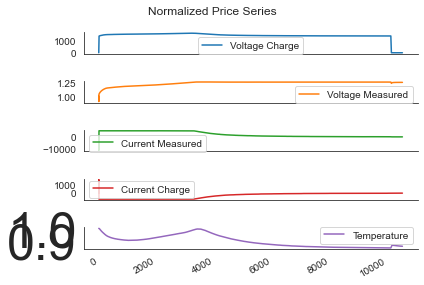

In [140]:
axes = df.div(df.iloc[0]).plot(subplots=True)
for ax in axes.flatten():
    ax.set_xlabel('')
    plt.yticks(fontsize = 50)

plt.suptitle('Normalized Price Series')
plt.gcf().tight_layout()
plt.savefig("fig54.pdf",bbox_inches="tight")

sns.despine();





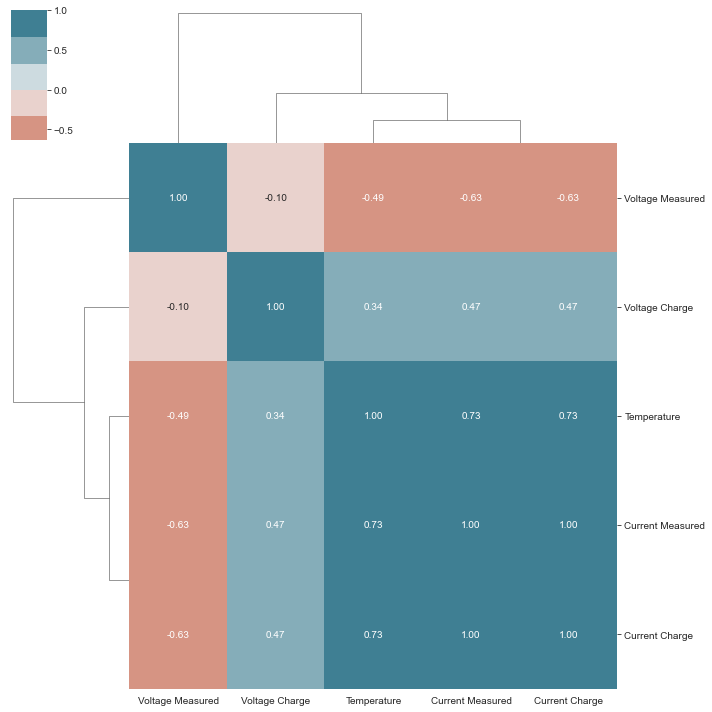

In [141]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

In [142]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

<AxesSubplot:xlabel='Time'>

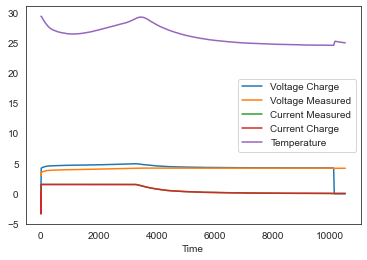

In [143]:
df.plot()

In [144]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)


In [145]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [146]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [147]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

In [148]:
#hidden_dim = 24_3
hidden_dim = 24
num_layers = 3

In [149]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

In [150]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

In [151]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

In [152]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

In [153]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

In [154]:
# train_steps = 100
# more train steps to get a better result
train_steps = 10000
gamma = 1

In [155]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

In [156]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [157]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 24, 5)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 24, 24)            10032     
_________________________________________________________________
Recovery (Sequential)        (None, 24, 5)             10925     
Total params: 20,957
Trainable params: 20,957
Non-trainable params: 0
_________________________________________________________________


In [158]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [159]:
import pydot

In [160]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [161]:
autoencoder_optimizer = Adam()

In [162]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [163]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:20<00:00, 26.29it/s]


In [164]:
# autoencoder.save(log_dir / 'autoencoder')

In [165]:
supervisor_optimizer = Adam()

In [166]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [167]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.45it/s]


In [168]:
# supervisor.save(log_dir / 'supervisor')

In [169]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [170]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 5)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            10032     
_________________________________________________________________
Supervisor (Sequential)      (None, 24, 24)            7800      
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 28,657
Trainable params: 28,657
Non-trainable params: 0
_________________________________________________________________


In [171]:
plot_model(adversarial_supervised, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [172]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [173]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 5)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            10032     
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 20,857
Trainable params: 20,857
Non-trainable params: 0
_________________________________________________________________


In [174]:
plot_model(adversarial_emb, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [175]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [176]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 5)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            10032     
_________________________________________________________________
Supervisor (Sequential)      (None, 24, 24)            7800      
_________________________________________________________________
Recovery (Sequential)        (None, 24, 5)             10925     
Total params: 28,757
Trainable params: 28,757
Non-trainable params: 0
_________________________________________________________________


In [177]:
plot_model(synthetic_data, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [178]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

In [179]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [180]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 24, 5)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 24, 24)            10032     
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 20,857
Trainable params: 20,857
Non-trainable params: 0
_________________________________________________________________


In [181]:
plot_model(discriminator_model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [182]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

In [183]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

In [184]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [185]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [186]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [187]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.1135 | g_loss_u: 0.6534 | g_loss_s: 0.0006 | g_loss_v: 0.2300 | e_loss_t0: 0.0355
 1,000 | d_loss: 1.2724 | g_loss_u: 1.5787 | g_loss_s: 0.0001 | g_loss_v: 0.0169 | e_loss_t0: 0.0013
 2,000 | d_loss: 1.7324 | g_loss_u: 1.1297 | g_loss_s: 0.0001 | g_loss_v: 0.0542 | e_loss_t0: 0.0024
 3,000 | d_loss: 1.6313 | g_loss_u: 1.1683 | g_loss_s: 0.0000 | g_loss_v: 0.0241 | e_loss_t0: 0.0018
 4,000 | d_loss: 1.8319 | g_loss_u: 1.1529 | g_loss_s: 0.0000 | g_loss_v: 0.0335 | e_loss_t0: 0.0016
 5,000 | d_loss: 1.8617 | g_loss_u: 1.0030 | g_loss_s: 0.0000 | g_loss_v: 0.0317 | e_loss_t0: 0.0016
 6,000 | d_loss: 1.6974 | g_loss_u: 0.9877 | g_loss_s: 0.0000 | g_loss_v: 0.0204 | e_loss_t0: 0.0020
 7,000 | d_loss: 1.7726 | g_loss_u: 1.1522 | g_loss_s: 0.0000 | g_loss_v: 0.0250 | e_loss_t0: 0.0014
 8,000 | d_loss: 1.8815 | g_loss_u: 1.1756 | g_loss_s: 0.0000 | g_loss_v: 0.0336 | e_loss_t0: 0.0013
 9,000 | d_loss: 1.8230 | g_loss_u: 1.1161 | g_loss_s: 0.0000 | g_loss_v: 0.0360 | e_loss_t

In [188]:
synthetic_data.save(log_dir / 'synthetic_data')

INFO:tensorflow:Assets written to: time_gan\experiment_00\synthetic_data\assets


INFO:tensorflow:Assets written to: time_gan\experiment_00\synthetic_data\assets


In [189]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [190]:
len(generated_data)

7

In [191]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(896, 24, 5)

In [192]:
np.save(log_dir / 'generated_data.npy', generated_data)

In [193]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(896, 24, 5)

In [194]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

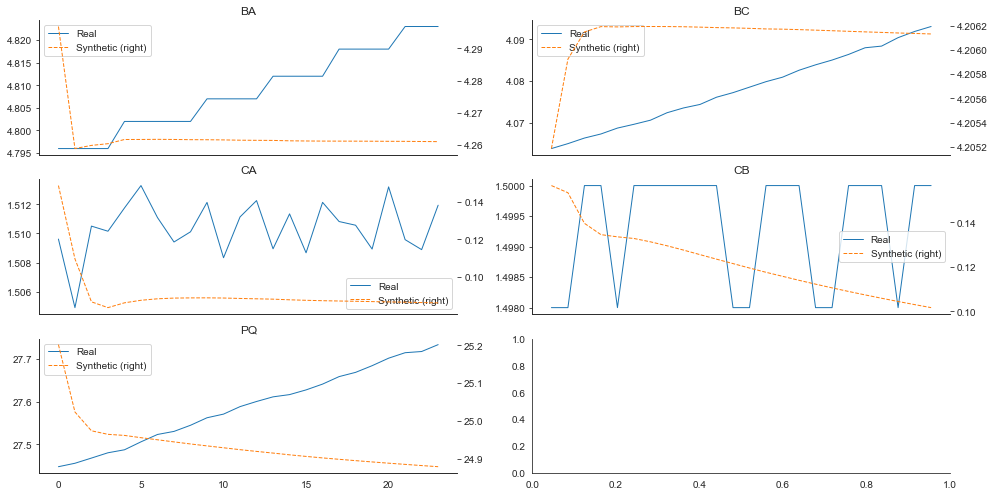

In [195]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})


     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()
fig.savefig("fig55.pdf",bbox_inches="tight")
     

In [198]:
#visualize real and synthetic data
def get_real_data():
    df = pd.read_csv('3.csv', 
                     index_col='Time', 
                     parse_dates=['Time']).sort_index()

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data


real_data = get_real_data()

In [199]:
n = len(real_data)

In [200]:
np.asarray(real_data).shape

(916, 24, 5)

In [201]:
synthetic_data = np.load(results_path / f'experiment_{experiment:02d}' / 'generated_data.npy')
synthetic_data.shape

(896, 24, 5)

In [202]:
real_data = real_data[:synthetic_data.shape[0]]

In [203]:
#preparing the sample
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [204]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [205]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [206]:
real_sample_2d.shape, synthetic_sample_2d.shape

((1250, 24), (1250, 24))

In [207]:
#Visulization in 2D: A quatitative assessment of diversity 

In [208]:
#Run PCA
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

In [209]:
#Run t-SNE
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.019s...
[t-SNE] Computed neighbors for 2500 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.064635
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.858414
[t-SNE] KL divergence after 1000 iterations: 0.242407


In [210]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

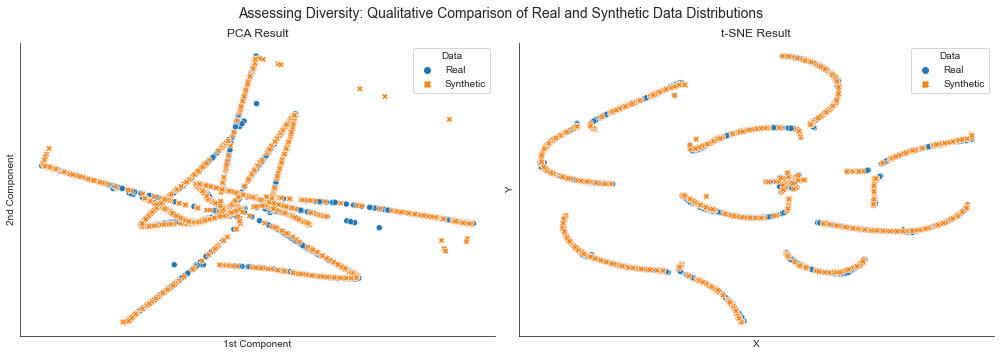

In [211]:
#PLOT RESULTS OF DIVERSITY
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88)
fig.savefig("fig59.pdf",bbox_inches="tight");

In [212]:
#Time Series Classification: A quantitative Assessment of Fidelity

In [214]:
#Prepare Data
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]
real_data.shape

(896, 24, 5)

In [215]:
synthetic_data.shape

(896, 24, 5)

In [216]:
n_series = real_data.shape[0]

In [217]:
idx = np.arange(n_series)

In [218]:
n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [219]:
train_data = np.vstack((real_data[train_idx], 
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], 
                       synthetic_data[test_idx]))

In [220]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

In [232]:
#Create Classifier
ts_classifier = Sequential([GRU(6, input_shape=(24, 5), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [233]:
ts_classifier.compile(loss='binary_crossentropy',
        optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [234]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, 6)                 234       
_________________________________________________________________
OUT (Dense)                  (None, 1)                 7         
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [235]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=250,
                           batch_size=128)

Epoch 1/250
12/12 [==============================] - 3s 57ms/step - loss: 0.7444 - AUC: 0.4210 - accuracy: 0.4985 - val_loss: 0.6853 - val_AUC: 0.9100 - val_accuracy: 0.5000
Epoch 2/250
12/12 [==============================] - 0s 11ms/step - loss: 0.7200 - AUC: 0.4217 - accuracy: 0.4977 - val_loss: 0.6654 - val_AUC: 0.8998 - val_accuracy: 0.5194
Epoch 3/250
12/12 [==============================] - 0s 12ms/step - loss: 0.7091 - AUC: 0.4106 - accuracy: 0.4942 - val_loss: 0.6595 - val_AUC: 0.9095 - val_accuracy: 0.6083
Epoch 4/250
12/12 [==============================] - 0s 11ms/step - loss: 0.7067 - AUC: 0.4000 - accuracy: 0.4813 - val_loss: 0.6589 - val_AUC: 0.8982 - val_accuracy: 0.6528
Epoch 5/250
12/12 [==============================] - 0s 12ms/step - loss: 0.7056 - AUC: 0.3840 - accuracy: 0.4531 - val_loss: 0.6625 - val_AUC: 0.9079 - val_accuracy: 0.6611
Epoch 6/250
12/12 [==============================] - 0s 12ms/step - loss: 0.7034 - AUC: 0.3953 - accuracy: 0.4577 - val_loss: 0.66

In [236]:
ts_classifier.evaluate(x=test_data, y=test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 2.1239 - AUC: 0.1204 - accuracy: 0.1306    


[2.123889446258545, 0.1203857883810997, 0.13055555522441864]

In [237]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [238]:
from matplotlib.ticker import FuncFormatter

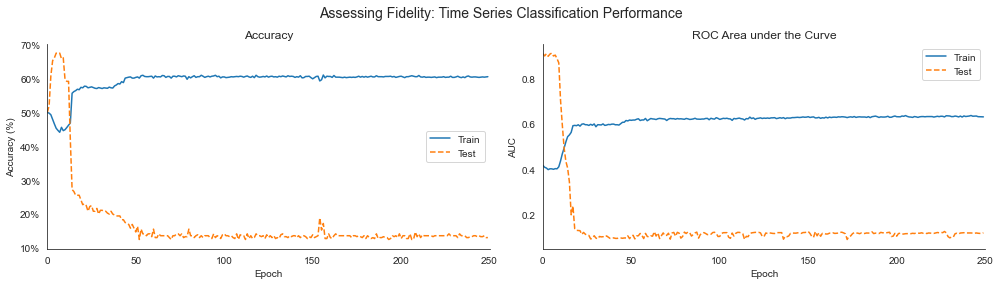

In [239]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig("fig60.pdf",bbox_inches="tight");

In [240]:
#Train on Synthetic, test on real: Assessing usefulness

In [241]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]

In [242]:
real_data.shape, synthetic_data.shape

((896, 24, 5), (896, 24, 5))

In [243]:
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]

In [244]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((716, 23, 5), (716, 5), (180, 23, 5), (180, 5))

In [245]:
synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]

In [246]:
synthetic_train.shape, synthetic_label.shape

((896, 23, 5), (896, 5))

In [250]:
def get_model():
    model = Sequential([GRU(12, 
                            input_shape=(seq_len-1, 
                                         n_seq)),
                        Dense(5)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

In [251]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128)


Epoch 1/100
7/7 [==============================] - 2s 68ms/step - loss: 0.7121 - val_loss: 0.4526
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 0.5805 - val_loss: 0.3756
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.4638 - val_loss: 0.3766
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 0.3711 - val_loss: 0.3739
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 0.3231 - val_loss: 0.3455
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 0.2806 - val_loss: 0.3025
Epoch 7/100
7/7 [==============================] - 0s 12ms/step - loss: 0.2366 - val_loss: 0.2692
Epoch 8/100
7/7 [==============================] - 0s 11ms/step - loss: 0.2007 - val_loss: 0.2272
Epoch 9/100
7/7 [==============================] - 0s 12ms/step - loss: 0.1708 - val_loss: 0.1924
Epoch 10/100
7/7 [==============================] - 0s 12ms/step - loss: 0.1422 - val_loss: 0.1982
Epoch 11/100
7/7 [=

In [252]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 
                                                                          'val_loss': 'Test'})

In [253]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [254]:
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 
                                                                'val_loss': 'Test'})

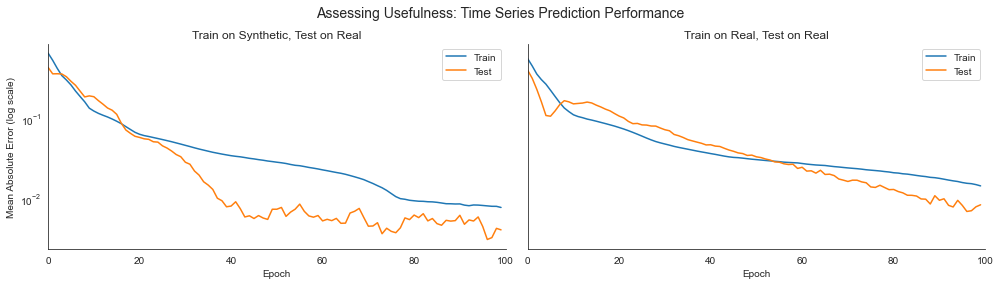

In [255]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', 
                      logy=True, 
                      xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', 
                 logy=True, 
                 xlim=(0, 100))

for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig("fig61.pdf",bbox_inches="tight");